# Final Project - 42578 Advanced Business Analytics (F22)
## Engagement prediction of news articles on Facebook

Technical University of Denmark (DTU), 11th of May 2022

*This notebook is made in collaboration between:*  
s184314  
s184288  
s184313  
s183568   
s184304   

*Contributions*

| Study ID | Part | Part |
| --- | --- | --- |
| s184314 |  |  |
| s184288 |  |  |
| s184313 |  |  |
| s183568 |  |  |
| s184304 |  |  |


#### Structure of this notebook

The notebook consists of the following parts: 
* [Part 1: Introduction to the project](#part1)  
  [1.1 Description of chosen dataset](#part11)  
  [1.2 Research questions](#part12)
* [Part 2: Data cleaning & Preprocessing](#part2)
* [Part 3: Descriptive statistics](#part3)
* [Part 4: Sentiment and Subjectivity Analysis](#part4)
* [Part 5: Topic modelling](#part5)
* [Part 6: Analysis of images](#part6)
* [Part 7: Correlations with engagement](#part7)
* [Part 8: Defining training and test set](#part8)
* [Part 9: Modelling](#part9)  
  [9.1 Baseline model](#part91)  
  [9.2 Light GBM regressor ](#part92)  
  [9.3 Convolutional neural network (CNN)](#part93)  
  [9.4 BERT model](#part94)  
  [9.5: ](#part95)  
  [9.6: ](#part96)

<a id='part1'></a>

# Part 1 - Introduction to the project

The topic of this project is *Engagement prediction of news articles on Facebook*. In order to perform a prediction of the engagement a thorough cleaning of the dataset will be carried out. Hereafter, descriptive statistics will take place, which explore the importance of the different attributes. Both low complexity models and high complexity models will be tested and evaluated to finally select the most suitable model for prediction article engagement on Facebook. 

<a id='part11'></a>
## 1.1 Description of chosen dataset
For the project the provided dataset *Internet news data with readers engagement* will be used. The dataset has been downloaded from [Kaggle](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement). 


The dataset contains basic information about the news articles and all attributes can be seen in the table below. 

| Attribute | Description | 
| :- | :- |
| source_id | Publisher unique identifier |
| source_name | Publisher name |
| author | The author of the article |
| title | The headline of the article |
| description | A short description of the article |
| url | Article URL from publisher website |
| url_to_image | URL to main image associated with the article |
| published_at | Exact time and date of publishing the article |
| content | Unformatted content of the article truncated to 260 characters |
| top_article | Value indicating if article was listed as a top article on publisher website |
| engagement_reaction_count | Users reactions count for posts on Facebook involving article URL |
| engagement_comment_count | Users comments count for posts on Facebook involving article URL |
| engagement_share_count | Users shares count for posts on Facebook involving article URL |
| engagement_comment_plugin_count | Users comments count for Facebook comment plugin on article website |


The dataset consists of 10.436 rows and 14 columns. The data was collected between 03.09.2019 and 03.10.2019 (DD.MM.YYYY). 


<a id='part12'></a>
## 1.2 Research questions

The aim of this project is to analyse how the facebook engagement of news articles is impacted by different attributes. Facebook engagement is important for news websites as it helps them reach beyond its followers. If a news website's Facebook page only has a small amount of followers, but most of them engage with their posts, then their content will appear on many non-followers' Facebook feed. This means that if the news websites achieves a high engagement rate, they will most likely reach a larger audiance in which they have potential to attract new readers to their platform. It is interesting to see if it is possible to predict the engagement of an article, as this has the potential to help publishers improve their engagement. This leads to the following research questions: 

* Which attributes contribute most to the engagement?

* What similarities can be found between the articles with a high engagement count?

* Is there a correlation between the sentiment of an article and the engagement? If so, how can this be used to predict engagement? 

* Which topics can be found in the dataset and can these be used for prediction? 

* What is the performance of a simple ML model? 

* Can the prediction be improved by using neural networks for modeling both the article content and image?

<a id='part2'></a>

# Part 2 - Data cleaning & Preprocessing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Loading all relevant packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.dates
import matplotlib.pyplot as plt
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
import textblob
from wordcloud import WordCloud,STOPWORDS
import re
import gensim
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
#from lightgbm import LGBMRegressor,LGBMClassifier
import cv2
import requests
import imageio
import urllib.request
import os
import os.path
from pathlib import Path
#import tensorflow as tf
#from tensorflow import keras
import PIL
from PIL import ImageFile,Image,UnidentifiedImageError
import pickle

plt.rcParams["figure.figsize"] = (20,5)
ImageFile.LOAD_TRUNCATED_IMAGES = True
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS

In [ ]:
# Let's load the data
df = pd.read_csv('articles_data.csv', index_col = 0)
df.head(5)

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count
0,reuters,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,https://www.reuters.com/article/us-tesla-crash...,https://s4.reutersmedia.net/resources/r/?m=02&...,2019-09-03T16:22:20Z,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,0.0
1,the-irish-times,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,https://www.irishtimes.com/business/economy/un...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T10:32:28Z,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,0.0
2,the-irish-times,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,https://www.irishtimes.com/\t\t\t\t\t\t\t/life...,https://www.irishtimes.com/image-creator/?id=1...,2019-09-03T14:40:00Z,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,NaN
3,al-jazeera-english,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,https://www.aljazeera.com/news/2019/09/north-k...,https://www.aljazeera.com/mritems/Images/2019/...,2019-09-03T17:25:39Z,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,0.0
4,bbc-news,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",https://www.bbc.co.uk/news/av/uk-scotland-4956...,https://ichef.bbci.co.uk/news/1024/branded_new...,2019-09-03T14:39:21Z,NaN,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Check the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10436 entries, 0 to 10436
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_id                        10436 non-null  object 
 1   source_name                      10436 non-null  object 
 2   author                           9416 non-null   object 
 3   title                            10434 non-null  object 
 4   description                      10412 non-null  object 
 5   url                              10435 non-null  object 
 6   url_to_image                     9780 non-null   object 
 7   published_at                     10435 non-null  object 
 8   content                          9144 non-null   object 
 9   top_article                      10434 non-null  float64
 10  engagement_reaction_count        10318 non-null  float64
 11  engagement_comment_count         10318 non-null  float64
 12  engagement_share_c

In [ ]:
print("The 'description' column has:", df.description.isna().sum(), "missing values")
print("The 'url_to_image' column has:", df.url_to_image.isna().sum(), "missing values")
engagement_missing = df[['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']].isna().sum()[0]
print("The 'engagement' columns has:", engagement_missing, "missing values")

The 'description' column has: 24 missing values
The 'url_to_image' column has: 656 missing values
The 'engagement' columns has: 118 missing values


We can see that the `description` attribute has 24 missing values, the `url_to_image` attribute has 656 missing value and all the `engagement` attributes have 118 missing values.

**Creating a new date column with yyyy-mm-dd** 

From the information of the dataset it can be seen that the `publised_at` attribute is defined as an object. This attribute is a date, thus it has to be transformed to date type. 

In [ ]:
df['Date'] = pd.to_datetime(df['published_at'])#.dt.tz_convert('US/Eastern')

In [ ]:
# We can now look at what the timeframe of the data is
print("The earliest date is:", df["Date"].min())
print("The latest date is:", df["Date"].max())

The earliest date is: 2019-09-03 00:00:00+00:00
The latest date is: 2019-10-03 17:49:31+00:00


There is row with missing date. We take a look at this row: 

In [ ]:
df[df.Date.isnull()]

,source_id,source_name,author,title,description,url,url_to_image,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,engagement_comment_plugin_count,Date
750,1,460.0,151.0,352.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [ ]:
# This code is from the following Kaggle (https://www.kaggle.com/code/thomaskonstantin/exploring-and-modeling-internet-news-data/notebook)

fig = make_subplots(rows=3, cols=1, subplot_titles=('Engagement Reaction Count','Engagement Comment Count','Engagement Share Count'))

b_date_mean = df.copy()
b_date_mean.published_at = pd.to_datetime(b_date_mean.published_at).dt.normalize()
b_date_mean = b_date_mean.groupby(by='published_at').mean().reset_index()

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_reaction_count,name='engagement_reaction_count'),
row=1, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_comment_count,name='engagement_comment_count'),
row=2, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_share_count,name='engagement_share_count'),
row=3, col=1)

fig.update_layout(height=600, width=900, title_text="Behavior Of Different Engagement Attributes Over Time")
fig.show()

The engagement reaction count, comment count and share count are plotted above. We can see that all engagement trends are similar. 



### Cleaning

In the following code the valid image url codes are found. If the row of an article contains an invalid url code or no url code is given, the value in the list is set to 0. 

In [ ]:
#function to process one image
def read_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return im

#function that outputs the image
def print_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return Image.fromarray(im).resize((500, 300), Image.ANTIALIAS)

In [ ]:
#WARNING: Takes a long time to run. Import the array instead.
'''
im_list = [] #Initialize empty list to store the valid urls

for i in range(len(df)): #loop through every article in the dataset
    print(i)
    url = df.iloc[i]["url_to_image"]
    
    if pd.isna(url) == False: #If there is an url in the row then try and open.
       
        try:
            im = read_image(df.iloc[i].url_to_image)
            im_list.append(url) #If the url is valid, it is appended to the list.
        except ValueError:
            im_list.append(0) #If the url is invalid, a zero is appended to the list.
            pass
        
    else:
        im_list.append(0) #If no url is given, a zero is appended to the list. 
'''

In [ ]:
#np.save('valid_urls_test', im_list) # save the file as "outfile_name.npy" 

In [ ]:
valid_im_urls = np.load('valid_urls_main.npy', allow_pickle=True)

In [ ]:
print("Number of valid url codes:", len(valid_im_urls)-valid_im_urls.tolist().count("0"))

Number of valid url codes: 9134


In [ ]:
#function to do rough cleaning of data

def text_preprocessing(text):
    text = "".join([c.lower() for c in text]) # lowercase
    return text

def clean_text(text):
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #remove hyperlink
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    # remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # lematizing
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    
    # remove numbers
    text = "".join([i for i in text if not i.isdigit()])
    
    #remove words of 1 letter length
    text= " ".join([word for word in text.split() if len(word) >= 2])
    
    return text

def drop_na(df):
    df = df.dropna(axis = 0)
    df = df[~(df['description'] == 'nan')]
    return df

#def continent(df):
 #   if df.source_name.isin(set('The Irish Times','Reuters','Al Jazeera English','BBC News')):
  #      df.continent = 'Europe'
   # else: df.continent = 'North America'
    #return df

def preprocessing(df):

    #make descriptions lower case
    df['description'] = df['description'].astype(str).apply(text_preprocessing)
    df['cleaned_description'] = df['description'].astype(str).apply(clean_text)
    df['title'] = df['title'].astype(str).apply(text_preprocessing)
    df['cleaned_title'] = df['title'].astype(str).apply(clean_text)
    
    #day of week
    df['Day_Of_Week'] = df.Date.apply(lambda x: x.dayofweek)
    
    #Hour of day
    df['Hour'] = df.Date.apply(lambda x: x.hour)
    
    df['Continent'] = np.where(df.source_name.isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']), 'Europe', 'North America')
    
    #select attributes of interest
    df = df[['Date', 'title', 'cleaned_title', 'description', 'url_to_image', 'engagement_reaction_count', 
             'engagement_comment_count', 'engagement_share_count', 'Date', 'Hour', 'Day_Of_Week', 'cleaned_description', 
             'top_article', 'source_name', 'Continent']]
    
    
    #dropping all rows with invalid image url
    del_ele = [i for i,value in enumerate(valid_im_urls) if value == '0'] # Index of elements to be deleted
    df.drop(del_ele, axis=0, inplace=True) # Delete the rows in the dataframe
    
    #drop nan's
    df = drop_na(df)
    
    #calculate engagement total 
    df['engagement'] = df['engagement_reaction_count'] + df['engagement_comment_count'] +df['engagement_share_count']
    #calculate engagement in log domain
    df['engagement_log'] = np.log1p(df['engagement'])
    
    df = df[['source_name', 'title', 'cleaned_title','description','cleaned_description', 'url_to_image', 
             'top_article', 'engagement', 'engagement_log', 'Date', 'Hour', 'Day_Of_Week', 'Continent']].copy()
    
    df['index'] = df.index #save the original index
    df = df.reset_index(drop=True) #reset index
    return df
#def continent(df):
#    for i in range(len(df.source_name)):
#        if df[i].source_name.isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']):
#            df[i].continent = 'Europe'
#        else: df[i].continent = 'North America'
#    return df

In [ ]:
#df['Continent'] = np.where(df['source_name'].isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']), 'England', 'USA')

In [ ]:
df = preprocessing(df)
df.head()

,source_name,title,cleaned_title,description,cleaned_description,url_to_image,top_article,engagement,engagement_log,Date,Date,Hour,Day_Of_Week,Continent,index
0,Reuters,ntsb says autopilot engaged in 2018 california...,ntsb say autopilot engaged california tesla crash,the national transportation safety board said ...,national transportation safety board said tues...,https://s4.reutersmedia.net/resources/r/?m=02&...,0.0,2528.0,7.835579,2019-09-03 16:22:20+00:00,2019-09-03 16:22:20+00:00,16.0,1.0,Europe,0
1,The Irish Times,unemployment falls to post-crash low of 5.2%,unemployment fall post crash low,latest monthly figures reflect continued growt...,latest monthly figure reflect continued growth...,https://www.irishtimes.com/image-creator/?id=1...,0.0,18.0,2.944439,2019-09-03 10:32:28+00:00,2019-09-03 10:32:28+00:00,10.0,1.0,Europe,1
2,Al Jazeera English,north korean footballer han joins italian gian...,north korean footballer han join italian giant...,han is the first north korean player in the se...,han north korean player serie praised appearan...,https://www.aljazeera.com/mritems/Images/2019/...,0.0,7.0,2.079442,2019-09-03 17:25:39+00:00,2019-09-03 17:25:39+00:00,17.0,1.0,Europe,3
3,BBC News,uk government lawyer says proroguing parliamen...,uk government lawyer say proroguing parliament...,"the uk government's lawyer, david johnston arg...",uk government lawyer david johnston argued pro...,https://ichef.bbci.co.uk/news/1024/branded_new...,0.0,0.0,0.000000,2019-09-03 14:39:21+00:00,2019-09-03 14:39:21+00:00,14.0,1.0,Europe,4
4,Reuters,eu wants to see if lawmakers will block brexit...,eu want lawmaker block brexit striking new dea...,the european union is waiting to see if britis...,european union waiting british lawmaker block ...,https://s2.reutersmedia.net/resources/r/?m=02&...,0.0,817.0,6.706862,2019-09-03 16:25:41+00:00,2019-09-03 16:25:41+00:00,16.0,1.0,Europe,6


In [ ]:
df

,source_name,title,cleaned_title,description,cleaned_description,url_to_image,top_article,engagement,engagement_log,Date,Date,Hour,Day_Of_Week,Continent,index,filepath
0,Reuters,ntsb says autopilot engaged in 2018 california...,ntsb say autopilot engaged california tesla crash,the national transportation safety board said ...,national transportation safety board said tues...,https://s4.reutersmedia.net/resources/r/?m=02&...,0.0,2528.0,7.835579,2019-09-03 16:22:20+00:00,2019-09-03 16:22:20+00:00,16.0,1.0,Europe,0,NaN
1,The Irish Times,unemployment falls to post-crash low of 5.2%,unemployment fall post crash low,latest monthly figures reflect continued growt...,latest monthly figure reflect continued growth...,https://www.irishtimes.com/image-creator/?id=1...,0.0,18.0,2.944439,2019-09-03 10:32:28+00:00,2019-09-03 10:32:28+00:00,10.0,1.0,Europe,1,NaN
2,Al Jazeera English,north korean footballer han joins italian gian...,north korean footballer han join italian giant...,han is the first north korean player in the se...,han north korean player serie praised appearan...,https://www.aljazeera.com/mritems/Images/2019/...,0.0,7.0,2.079442,2019-09-03 17:25:39+00:00,2019-09-03 17:25:39+00:00,17.0,1.0,Europe,3,NaN
3,BBC News,uk government lawyer says proroguing parliamen...,uk government lawyer say proroguing parliament...,"the uk government's lawyer, david johnston arg...",uk government lawyer david johnston argued pro...,https://ichef.bbci.co.uk/news/1024/branded_new...,0.0,0.0,0.000000,2019-09-03 14:39:21+00:00,2019-09-03 14:39:21+00:00,14.0,1.0,Europe,4,NaN
4,Reuters,eu wants to see if lawmakers will block brexit...,eu want lawmaker block brexit striking new dea...,the european union is waiting to see if britis...,european union waiting british lawmaker block ...,https://s2.reutersmedia.net/resources/r/?m=02&...,0.0,817.0,6.706862,2019-09-03 16:25:41+00:00,2019-09-03 16:25:41+00:00,16.0,1.0,Europe,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8791,ABC News,drop in us service sector activity raises econ...,drop service sector activity raise economic co...,"get breaking national and world news, broadcas...",breaking national world news broadcast video c...,https://s.abcnews.com/images/US/WireAP_eb147c9...,0.0,0.0,0.000000,2019-10-03 16:30:16+00:00,2019-10-03 16:30:16+00:00,16.0,3.0,North America,10432,NaN
8792,Reuters,banker defections pose challenge for credit su...,banker defection pose challenge credit suisse ...,the announcement by julius baer this week that...,announcement julius baer week hired senior ban...,https://s3.reutersmedia.net/resources/r/?m=02&...,0.0,627.0,6.442540,2019-10-03 15:59:52+00:00,2019-10-03 15:59:52+00:00,15.0,3.0,Europe,10433,NaN
8793,CNN,"a 5-year-old cancer survivor donates 3,000 toy...",year old cancer survivor donates toy child hos...,weston newswanger is just a normal 5-year-old ...,weston newswanger just normal year old boy com...,https://cdn.cnn.com/cnnnext/dam/assets/1910021...,0.0,4717.0,8.459140,2019-10-03 11:20:06+00:00,2019-10-03 11:20:06+00:00,11.0,3.0,North America,10434,NaN
8794,CBS News,fateful connection,fateful connection,a detective is haunted by the case of two wome...,detective haunted case woman missing year hot ...,https://cbsnews1.cbsistatic.com/hub/i/r/2019/1...,0.0,0.0,0.000000,2019-10-03 16:40:03+00:00,2019-10-03 16:40:03+00:00,16.0,3.0,North America,10435,NaN


In [ ]:
len(df)

8796

**Downloading all valid images**

In [ ]:
#WARNING: This has a long runtime. 
''''
for i in range(len(df)):
    try: 
        response = requests.get(df.iloc[i].url_to_image)
        file = open("/Users/ceciliekosack/Documents/Images_correct/"+str(i)+".jpg", "wb")
        file.write(response.content)
        file.close()
    except:
        print(i)
        pass
''''

Not all images were downloaded successfully. These has to be delete from the dataframe. 

To be begin with a column with the filepath is added:

In [ ]:
len(df)

8796

In [ ]:
df['filepath'] = ["drive/MyDrive/ABA project/Images/"+str(i)+'.jpg' for i in range(len(df))]

In [ ]:
#for i in range(len(df)):
    #df["filepath"][i] = "drive/MyDrive/ABA project/Images/"+str(i)+'.jpg'

In [ ]:
df["filepath"].iloc[0]

'drive/MyDrive/ABA project/Images/0.jpg'

In [ ]:
#WARNING
'''
failures = []
for img_p in df.filepath:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        failures.append(img_p)
        print(img_p)
'''

'\nfailures = []\nfor img_p in df.filepath:\n    try:\n        img = PIL.Image.open(img_p)\n    except PIL.UnidentifiedImageError:\n        failures.append(img_p)\n        print(img_p)\n'

In [ ]:
#np.save('failures', failures_list) # save the file as "outfile_name.npy" 

In [ ]:
failures_list = np.load('failures.npy', allow_pickle=True)

In [ ]:
df['index_old'] = df.index #save the original index

In [ ]:
df = df[~df['filepath'].isin(failures_list)]

In [ ]:
df = df.reset_index(drop=True) #reset index

In [ ]:
len(df)

8720

Deleting the failed images and renaming all images to match their new index.

In [ ]:
df = df.reset_index(drop=True) #reset index

In [ ]:
#Deleting the failed images
for i in (failures_list):
    os.remove(i)

In [ ]:
#Renaming images to match their index
for i in range(len(df)): 
    old_name = df.iloc[i]['index_old']
    new_name = i
    os.rename("drive/MyDrive/ABA project/Images/"+str(old_name)+'.jpg', "drive/MyDrive/ABA project/Images/"+str(new_name)+'.jpg')

The filepath should also be updated:

In [ ]:
df['filepath'] = ["drive/MyDrive/ABA project/Images/"+str(i)+'.jpg' for i in range(len(df))]

In [ ]:
#df['filepath'] = np.nan
#for i in range(len(df)):
    #df["filepath"][i] = "drive/MyDrive/ABA project/Images/"+str(i)+'.jpg'

In [ ]:
#df.to_csv('df_main_new.csv')

<a id='part3'></a>


## Part 3: Descriptive statistics

**How many `top_article`=1 do we have?**

In [ ]:
df = pd.read_csv('df_main_new.csv',index_col = 0, keep_default_na=False)
df = df.drop(['index','index_old'], axis = 1)

In [ ]:
fig = px.pie(values=df.index.value_counts().values, names=df['top_article'])
fig.show()

**Looking at the occurences of each data source/news page**

In [ ]:
source_plot = df.source_name.value_counts()

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='#Observations')
fig.update_xaxes(type='category')
fig.show()

**Looking at the engagement of each data source/news page**

In [ ]:
eng_plot = df.groupby(['source_name']).engagement.mean().sort_values(ascending=False)

fig = px.bar(x=eng_plot.index, y = eng_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.show()

**Time plots**

In [ ]:
plot = df.groupby(['Day_Of_Week']).engagement.mean()#.sort_values(ascending=False)

fig = px.bar(x=plot.index, y = plot.values, height=500, width=800)
fig.update_xaxes(title_text='Day of week')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.update_layout(
    xaxis = dict(tickmode = 'array',
                 tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))
fig.show()

In [ ]:
plot = df.groupby(['Continent', 'Hour']).engagement.mean().reset_index()

fig = px.bar(plot, x='Hour', y = 'engagement', color = 'Continent', barmode = 'group', height=500, width=800)
fig.update_xaxes(title_text='Hour (UTC)')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.show()

kommentér på at det er mærkeligt der ikke er nogen mellem 15 og 20.

**Looking at the distribution of engagement**

In [ ]:
fig = px.histogram(df, x='engagement', nbins=50, log_y=True)
fig.show()

In [ ]:
fig = px.histogram(df, x='engagement_log', nbins=50)
fig.show()

### Wordclouds

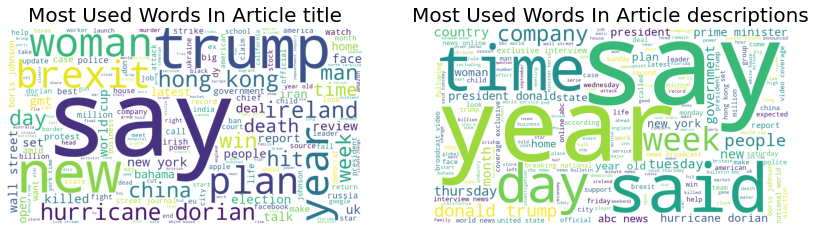

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,14])
wc1 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_title))
wc2 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_description))
ax1.imshow(wc1)
ax2.imshow(wc2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title("Most Used Words In Article title",fontsize=20)
ax2.set_title("Most Used Words In Article descriptions",fontsize=20)
plt.show()

<a id='part4'></a>

## Part 4: Sentiment and Subjectivity Analysis

After having gone through some desciptive statistics of the article data set, more complex analysis can now be carried out. This is here done by looking into the text of the articles. Analyzing language is called Natural Language Processing (NLP) and contains a variety of topics - some of them are sentiment and subjectivity analysis which is covered in this section. 

The analysis have two main goals. Firstly, to provide sentiment and subjectivity scores in order to see, whether or not these can explain the engagement for articles and secondly to be a tool for getting better insight of the data. The tool used is [TextBlob](https://textblob.readthedocs.io/en/dev/), which is a library for processing textual data. It provides an API for diving into NLP tasks such as the ones used in this section.

The sentiment tool gives a result between -1 and 1, where -1 implies that the article is written in a very negative language, 0 implies neutral language and a score of 1 implies very positive language. The subjectivity tool provides a score between 0 and 1, where 0 is very objective and 1 very subjective language.

Even before carrying out the analysis one should assume that most articles are written in a neutral and objective language, however it is still interesting to see whether or not this assumption actually holds, and if there is any difference between the language of the different publishers.

In [ ]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# functions to label the articles
def analysis_sent(score):
    if score >= 0.5:
        return 'Positive'
    elif score <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'

def analysis_subj(score):
    if score >= 0.5:
        return 'Subjective'
    else:
        return 'Objective'

In [ ]:
#Creating columns for sentiment and subjectivity
df['subjectivityScore'] = df['cleaned_description'].apply(getSubjectivity)
df['polarityScore'] = df['cleaned_description'].apply(getPolarity)
df['polarity'] = df['cleaned_description'].apply(getPolarity).apply(analysis_sent)
df['subjectivity'] = df['cleaned_description'].apply(getSubjectivity).apply(analysis_subj)

In [ ]:
#slicing dataframe
positive_art=df[df['polarity']=='Positive']
neutral_art=df[df['polarity']=='Neutral']
negative_art=df[df['polarity']=='Negative']
subj=df[df['subjectivity']=='Subjective']
obj=df[df['subjectivity']=='Objective']

#saving counts for ploting and printing
print("Total number of articles:", len(df))
count_neg=len(negative_art)
count_neu=len(neutral_art)
count_pos=len(positive_art)
count_subj=len(subj)
count_obj=len(obj)
print("Number of negative articles:", count_neg)
print("Number of neutral articles:", count_neu)
print("Number of positive articles:", count_pos)
print("Number of subjective articles:", count_subj)
print("Number of objective articles:", count_obj)

Total number of articles: 8720
Number of negative articles: 172
Number of neutral articles: 8082
Number of positive articles: 466
Number of subjective articles: 2437
Number of objective articles: 6283


The figure below shows the distribution of the sentiment scores. Clearly, the assumption of neutral language holds for the most part. However, more than 5% of the articles are classified as positive and the histogram on the right shows, that there are articles placed in every single bin - implying that there are both articles with very negative and positive language in the data set. 

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','gold','indianred'] #Setting the color
labels = 'Positive', 'Neutral', 'Negative' #Setting the labels
values = [count_pos, count_neu, count_neg] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(negative)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Negative']['polarityScore'],
                           name="Negative",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(positive)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Positive']['polarityScore'],
                           name="Positive",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(neutral)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Neutral']['polarityScore'],
                           name="Neutral",marker=dict(color="gold"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Sentiment distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

The chart below shows the distribution of positive, negative and neutral articles in percentage of the total amount of articles published by each source. Interesting to see is that some publishers clearly writes in a more neutral language than others. The most neutral being Reuters with $<$2% positive and $<$1% negative articles. At the other extreme BBC News have more than 12% of their articles classified as using positive language and 2.7% as negative.

In [ ]:
grouped_count=df.groupby(['source_name','polarity']).count().reset_index()
grouped_count=grouped_count[['source_name','polarity','description']] 
grouped_count['description'] = grouped_count['description'] / grouped_count.groupby('source_name')['description'].transform('sum')*100
grouped_count#Plotting

fig = px.bar(grouped_count, x="source_name", y="description", color="polarity", title="Sentiment distribution per publisher",
             labels={'description':'%','source_name':'Publisher','polarity':''}, color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'})
for data in fig.data:
    data["width"] = 0.6 #Change this value for bar widths

fig.update_layout(hovermode="x unified",title_x=0.5, legend=dict(
        x=1.0,
        y=0.5,        
    ))

config = {'displayModeBar': False}
fig.show(config=config)

The next chart shows the distribution of subjectivity scores. Again, the assumption of objective language in articles hold for the most part, but actually $\sim$28% of the articles are classified as using subjective language. Important to note is that the threshold is set at 0.5, meaning that not all of the "subjective" articles are very subjective - this can also be seen in the histogram on the right 

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','indianred'] #Setting the color
labels = 'Objective', 'Subjective' #Setting the labels
values = [count_obj, count_subj] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(Subjective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Subjective']['subjectivityScore'],
                           name="Subjective",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(Objective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Objective']['subjectivityScore'],
                           name="Objective",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Subjecivity distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

To end this section, the average subjectivity score is shown for each publisher. Here it can be seen that all of the sources on average would be classified as using objective language as the average scores are below 0.5. Most of them are scored somwhere between 0.27 and 0.36 with only Business Insider being significantly more subjective on average and ABC News and Al Jazeera English being more objective on average.

In [ ]:
source_plot = df.groupby('source_name').subjectivityScore.mean().sort_values(ascending=False)

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Publisher')
fig.update_yaxes(title_text='Avg. subjectivity score')
fig.update_xaxes(type='category')
fig.show()

<a id='part5'></a>

## Part 5: Topic modelling

This section aims to investigate how the text content of the articles best can be devided into topics. This is done for two main reasons. Firstly, as the goal of this study is to predict the engagement, it could seem likely that the topic of an article have an influence on the popularity of it. Secondly, it can serve as a descriptive tool to better understand, what was the main topics in the article during the time of the data set.

The study will use [Latent DirichletAllocation (LDA)](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158) to perform topic modeling on the data. It consists of two main parts; generating topics and assigning topics to the articles. Each of the articles will then be able to be described by a distribution of topics and each of the topics are described by a distribution of words. To do this analysis, an article's description will be used and more specifically, the cleaned version made in the Data Cleaning section. This is done as the model input only should contain meaningfull words in order to reduce noise - as for the sentiment analysis. 

At last, the input to the model is a collection of all the descriptions of articles - namely the 'corpus'. The topic model is first implemented to generate topics and label each article with the most appropriate topic. The model determines the optimal number of topics to represent the lyrics corpus based on a measure of [coherence](https://radimrehurek.com/gensim/models/coherencemodel.html). It should be noted that the LDA usually initializes with random variables and thus it could generate slightly different topics every time if a seed is not set.

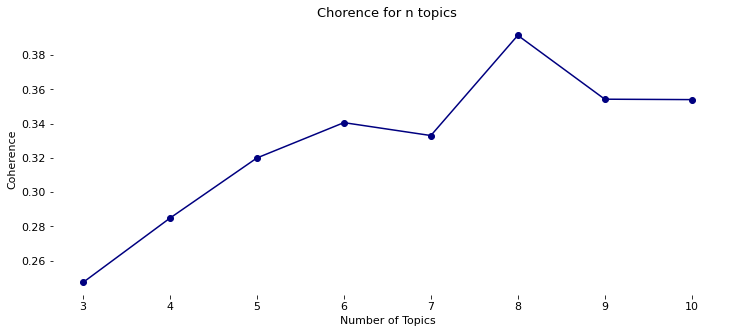

In [ ]:
#Prepping model inputs
corpus = df['cleaned_description'].values.tolist()
tok_corp= [word_tokenize(sent) for sent in corpus]
lexi = corpora.Dictionary(tok_corp)
corpus = [lexi.doc2bow(d) for d in tok_corp]

plt.figure(figsize=(12, 5))

#Choose n parameter based on coherence measure
coherence_vals = []
for k in range(3,11):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k,id2word = lexi, eval_every=None,passes=3,
               iterations=5,chunksize=100,random_state=123)

    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=tok_corp, dictionary=lexi, coherence='c_v')   

    coherence_vals.append((k,cm.get_coherence()))

n_topics = [x[0] for x in coherence_vals]
coherence = [x[1] for x in coherence_vals]

plt.plot(n_topics,coherence,color='navy')
plt.scatter(n_topics,coherence,color='navy')
plt.xlabel('Number of Topics',fontsize=11,color='black')
plt.ylabel('Coherence', fontsize=11,color='black')
plt.xticks(n_topics,fontsize=11,color='black')
plt.yticks(fontsize=11,color='black')
plt.title('Chorence for n topics',fontsize=13,color='black')
plt.box(False)

#plt.show()

From the coherence measure the optimal number of topics is $n=8$. Again, with the reservation that this is only run for 3 to 10 topics and that it can change due to the randomness of the model.

In [ ]:
#Running the LDA model with the optimal number of topics found above
n_sub_topics= 3+coherence.index(max(coherence))
lda = LdaModel(corpus=corpus, id2word=lexi, iterations=5,chunksize=100, passes=3,num_topics=n_sub_topics, 
          update_every=1, alpha='auto', random_state=123,eval_every=None)

In [ ]:
#Finding the topics 
topic_data =  pyLDAvis.gensim_models.prepare(lda, corpus, lexi, mds = 'pcoa')
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.8# Adjust this accordingly based on tuning above
for i in range(1,n_sub_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    topic_df = pd.DataFrame(all_topics).T
#Display keywords that represents each topic
topic_df

,0,1,2,3,4,5,6,7,8,9
Topic 1,say,week,wednesday,said,woman,minister,report,prime,latest,european
Topic 2,said,thursday,china,company,stock,ukraine,month,trade,market,country
Topic 3,year,old,just,target,case,investigates,october,killer,th,health
Topic 4,president,trump,state,donald,officer,hour,home,read,dead,photo
Topic 5,new,time,million,york,city,inquiry,son,start,quarter,season
Topic 6,police,people,day,like,joe,biden,morning,life,killed,open
Topic 7,story,business,house,impeachment,way,investor,deal,told,phone,want
Topic 8,news,world,national,video,online,interview,coverage,breaking,exclusive,abc


The 8 topics and their 10 most key words are shown above in the table. Safe to say that many of the topics somewhat related to politics. In topic 1 there are words such as *Prime* and *Minister*, topic 4 is related to *President Donald Trump* and Topic 6 contains *Joe Bidens* name. Then there is topic 3 which seems to be about crime cases containing words as *Case*, *Invastigates* and *Killer*, and a *Breaking News* topic in topic 8.

The performance of the LDA can be examined further by used the interactive visualizer as shown below. Here the topics are shown in a 2D space on he left and the chart on the right shows the words that describes the given topic. This bar chart on the right is linked to the tunable $\lambda$-parameter which is based on the TF-IDF. A high $\lambda$-value gives more importance to the term frequency and vice versa.

In [ ]:
pyLDAvis.display(topic_data)

The articles are now assigned to the different topics. With this it is possible to look at the relevance of topics in the context of engangement prediction a little later.

In [ ]:
train_vecs = []
for i in range(len(df)):
    top_topics = lda.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3+coherence.index(max(coherence)))]
    train_vecs.append(topic_vec)

In [ ]:
topics = pd.DataFrame(train_vecs,columns = ['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8'])
df = pd.concat([df, topics], axis=1)

<a id='part6'></a>

## Part 6: Analysis of images

This section reads the image urls and explores the colors of the images in the articles. This is done to explore whether a simple measurement of an article's image can help explain the engagement. The analysis is based on [HSV](https://realpython.com/python-opencv-color-spaces/) colors, which stands for the Hue, Saturation and Value (brightness) of an image. This color space is partifularly useful for identifying contrasts in images.

The following function process an image and finds the HSV colors by using the `cv2` package. Finally it takes the mean value of the HSV colors for each image.

In [ ]:
#function to process one image
def process_image(url):
    res = requests.get(url) # get image url
    im = imageio.imread((res.content)) # read image url

    #getting the HSV colors
    hue_mean, sat_mean, bright_mean = cv2.mean(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))    
    
    #return mean HSV values
    return hue_mean,sat_mean,bright_mean

In [ ]:
'''
df[['img_hue', 'img_sat', 'img_val']] = np.nan
'''

#WARNING: This code has a very long runtime. The output data has been saved in a new csv. So download this instead.
'''
for i in range(len(df)): # Loop through every article
    hue_mean,sat_mean,bright_mean = process_image(url)
    df["img_hue"][i], df["img_sat"][i], df["img_val"][i] = hue_mean,sat_mean,bright_mean

In [ ]:
#df.to_csv('df_hsv.csv')

In [ ]:
hsv = pd.read_csv("df_hsv.csv", index_col=0)
hsv=hsv[['img_hue','img_sat','img_val']]
df = pd.concat([df,hsv], axis=1)

Let's check if the found HSV values makes sense, by printing the images with the highest and lowest values.

In [ ]:
print("Row with highest Saturation:", df['img_sat'].idxmax())
print("Row with highest Brightness:", df['img_val'].idxmax())
print("--------------------------------------------")
print("Row with lowest Saturation:", df['img_sat'].idxmin())
print("Row with lowest Brightness:", df['img_val'].idxmin())

Row with highest Saturation: 1650
Row with highest Brightness: 527
--------------------------------------------
Row with lowest Saturation: 14
Row with lowest Brightness: 3593


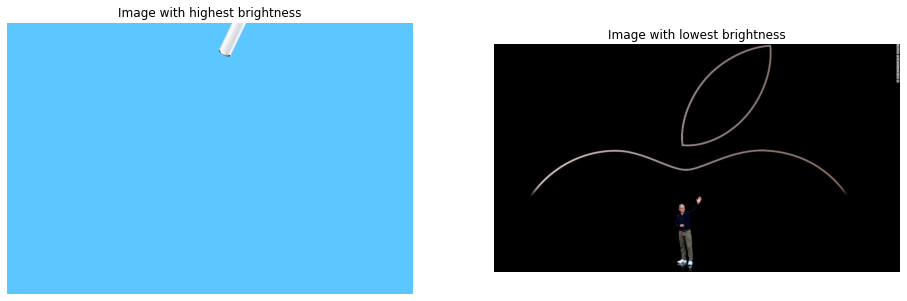

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(imageio.imread(df.iloc[df['img_val'].idxmax()].url_to_image))
ax[1].imshow(imageio.imread(df.iloc[df['img_val'].idxmin()].url_to_image))
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest brightness')
ax[1].set_title('Image with lowest brightness')
plt.show()

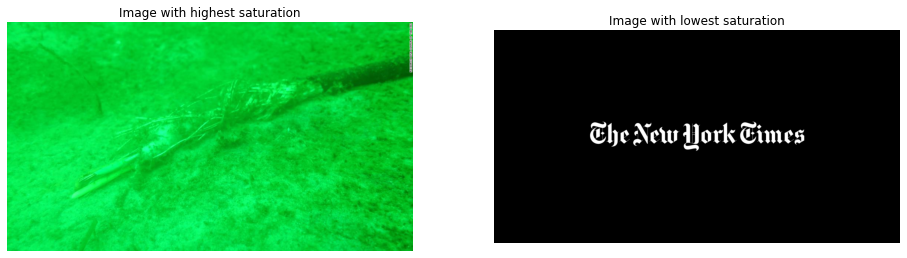

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(imageio.imread(df.iloc[df['img_sat'].idxmax()].url_to_image))
ax[1].imshow(imageio.imread(df.iloc[df['img_sat'].idxmin()].url_to_image))
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest saturation')
ax[1].set_title('Image with lowest saturation')
plt.show()

The extracted HSV colors of the images is assumed to be accurate as the lowest and highest values of brightness and saturation revealed the expected result.

<a id='part7'></a>

## Part 7: Correlations with engagement

The data has now been cleaned and preprocessed, such that it contains only valid rows and the right format for all attributes. This section looks at the correlation between the `engagement` and all relevant attributes mentioned in the above sections.

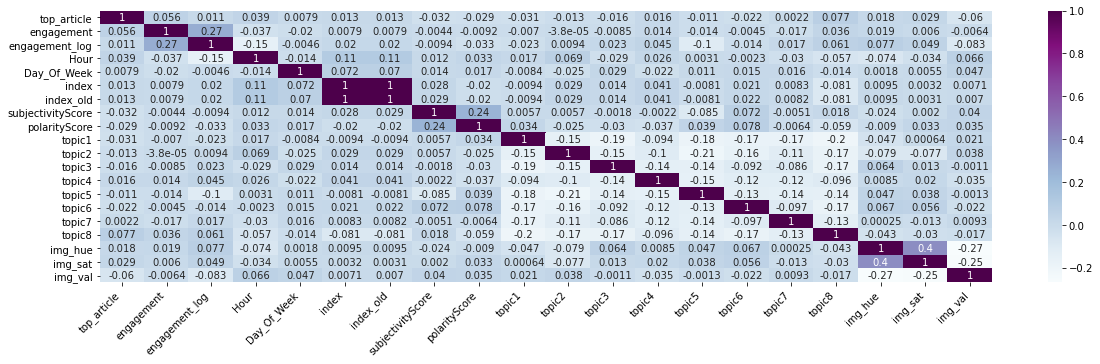

In [ ]:
g = sns.heatmap(df.corr(), cmap="BuPu", annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

From the correlation plot above, it can be concluded, that the `engagement` has very low correlation with all other attributes. The highest correlation is 0.056 with the attribute `top_article` followed by -0.037 with `Hour`and 0.036 with `topic8`. However, these corresponds to no correlation. 

<a id='part8'></a>

## Part 8: Defining training and test set

To evaluate the generalization error of our models we need to split the data. We split it into a train (72%), val (8%) and test (20%) set.

In [ ]:
y = np.array(df[['engagement','engagement_log','top_article']])
X = np.array(df[['source_name','title','cleaned_title','description','cleaned_description', 
                 'url_to_image','filepath','polarityScore','subjectivityScore']])
X_par, X_test, y_par, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_par, y_par, test_size=0.10, random_state=42)

In [ ]:
X_train=pd.DataFrame(X_train, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                       'polarityScore','subjectivityScore'])
X_val=pd.DataFrame(X_val, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                   'polarityScore','subjectivityScore'])
X_test=pd.DataFrame(X_test, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                     'polarityScore','subjectivityScore'])

y_train = pd.DataFrame(y_train, columns=['engagement','engagement_log', 'top_article'])
y_val = pd.DataFrame(y_val, columns=['engagement','engagement_log', 'top_article'])
y_test = pd.DataFrame(y_test, columns=['engagement','engagement_log', 'top_article'])

In [ ]:
pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(X_val, open("X_val.p", "wb"))
pickle.dump(y_val, open("y_val.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))

In [ ]:
#df.to_csv('df_cleaned.csv')

<a id='part9'></a>

## Part 9: Modelling

article review --> https://towardsdatascience.com/analyzing-and-predicting-consumer-engagement-8b3229f0cbad. Forklar hvad artiklen har gjort, og hvad vi vil gøre. 

In [ ]:
X_train = pickle.load(open("X_train.p", "rb"))
X_val =  pickle.load(open("X_val.p", "rb"))
X_test =  pickle.load(open("X_test.p", "rb"))
y_train = pickle.load(open("y_train.p", "rb"))
y_val = pickle.load(open("y_val.p", "rb"))
y_test = pickle.load(open("y_test.p", "rb"))

<a id='part91'></a>

### 9.1 Baseline (mean)

In [ ]:
y_pred = np.mean(y_train['engagement_log'])
y_pred = np.array([y_pred]*len(y_test))

In [ ]:
print("RMSE: ",round(np.sqrt(mean_squared_error(y_pred,y_test['engagement_log'])),2))

RMSE:  2.65


<a id='part92'></a>

### 9.2 Light GBM regressor

In [ ]:
X_train = pd.concat([X_train,X_val], axis = 0)
y_train = pd.concat([y_train,y_val], axis = 0)

In [ ]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(X_train['cleaned_description'])
test_tfidf = tfidf_vec.transform(X_test['cleaned_description'])

In [ ]:
model1 = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

In [ ]:
model1.fit(train_tfidf,y_train['engagement_log'])
pred1 = model1.predict(test_tfidf)
print("RMSE: ",round(np.sqrt(mean_squared_error(pred1,y_test['engagement_log'])),2))

RMSE:  2.57


<a id='part93'></a>


### 9.3 Convolutional neural networks (CNNs) - Tekst er ikke færdig

Source: [link](https://link-springer-com.proxy.findit.cvt.dk/content/pdf/10.1007/978-1-4842-6649-6.pdf)  

**Introduction to CNN**  
Convolutional neural networks (CNNs) are a specialized type of neural network models designed for working with two-dimensional image data. In a CNN an image is processed by assigning importance to various elements in it, which enables it to differentiate between images. The core building block of CNN is the convolutional layer. Such a layer contains a series of filters that transform an input image by extracting features into feature maps. The new feature map is then fed to the next layer in the network. Hence, a feature map captures the result of applying a convolutional layer. During the convolutional layer a small matrix, called a kernel, slides across the entire height and width of the input image. The CNN consists of multiple layers. 

**Implementation of CNN**

The input for the CNN is an image, with 3 channels, namely the RGB colors. 

The CNN consists of multiple layers. In the implementation of the CNN several convolutional layers will be applied together with pooling layers. The pooling layers shrinks the size of the input image to reduce the computation. In this implementation of CNN a max pooling will be used. Max pooling takes the maximum input of a convolved feature map. Furthermore, the CNN is build with a ReLU (rectified linear unit) activation function, which ensures nonlinearity. Finally, a global max pooling layer is applied in order to reduce the dimensions from 3D to 1D. This allows the CNN to perform classification. 

- ```kernel_size``` - In the first convolutional layer a kernel with size 5 x 5 is used. In the second convolutional layer a kernel with size 3 x 3 is used.   

- ```activation function``` - ReLU.   

- ```filters``` - In the first convolutional layer 32 filters is used. In the second convolutional layer 64 filters is used.  

- ```batch_size``` - Calculating gradients over all the data is usually time-consuming. That's why the training data is usually divided into chunks called "mini-batches". Although the gradients, in this case, become approximate, on practice, it even helps to get better solutions, for example, by escaping from local minima of the loss function.

- ```output layer``` - For regression a linear activation function is used. For binary classification a sigmoid activation function is used.  

The CNN will be implemented using `Keras`.

In [ ]:
# Defining training, validation and test dataframes
train_df = pd.DataFrame({'filepath': X_train['filepath'], 'engagement_log': y_train['engagement_log']})
val_df = pd.DataFrame({'filepath': X_val['filepath'], 'engagement_log': y_val['engagement_log']})
test_df = pd.DataFrame({'filepath': X_test['filepath'], 'engagement_log': y_test['engagement_log']})

In [ ]:
# Normalizing pixel values from [0, 255] to [0, 1]
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # Training set
    x_col='filepath', # Independent variable
    y_col='engagement_log', # Dependent variable
    target_size=(120, 120), # Resizing images, total of 14,400 pixels in each picture
    color_mode='rgb', # Using RGB colors, three channels
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df, # Validation set
    x_col='filepath', # Independent variable
    y_col='engagement_log', # Dependent variable
    target_size=(120, 120), # Resizing images, total of 14,400 pixels in each picture
    color_mode='rgb', # Using RGB colors, three channels
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, # Test set 
    x_col='filepath', # Independent variable
    y_col='engagement_log', # Dependent variable
    target_size=(120, 120), # Resizing images, total of 14,400 pixels in each picture
    color_mode='rgb', # Using RGB colors, three channels
    class_mode='raw',
    batch_size=32,
    shuffle=False)

Found 6278 validated image filenames.
Found 698 validated image filenames.
Found 1744 validated image filenames.


In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3)) # 120x120 images with 3 layers/channels (RGB colors)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inputs) # First convolutional layer
x = tf.keras.layers.MaxPool2D()(x) # First pooling layer, data is 3D
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x) # Second convolutional layer 
x = tf.keras.layers.MaxPool2D()(x) # Second pooling layer, data is 3D
x = tf.keras.layers.GlobalMaxPooling2D()(x) # Final pooling layers, that transforms the data to be 1D
x = tf.keras.layers.Dense(64, activation='relu')(x) # Dense layer
outputs = tf.keras.layers.Dense(1, activation='linear')(x) # Output layer

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse') # Mean squared error

The model can be trained using the ```fit()``` function. Some parameters to specify:
- ```epochs``` - Number of epochs to be used. One epoch corresponds to one pass through the whole train data. If ```batch_size=len(x_train)```, then one batch corresponds to one epoch.
- ```validation_data``` - The data to be used not for the test purposes on-the-fly (to detect overfitting).

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)])

Epoch 1/100
197/197 [==============================] - 1841s 9s/step - loss: 7.8111 - val_loss: 6.9995
Epoch 2/100
197/197 [==============================] - 127s 645ms/step - loss: 7.0416 - val_loss: 6.7352
Epoch 3/100
197/197 [==============================] - 126s 642ms/step - loss: 6.9132 - val_loss: 6.6958
Epoch 4/100
197/197 [==============================] - 128s 650ms/step - loss: 6.8309 - val_loss: 6.6791
Epoch 5/100
197/197 [==============================] - 126s 641ms/step - loss: 6.7935 - val_loss: 6.6772
Epoch 6/100
197/197 [==============================] - 123s 624ms/step - loss: 6.7372 - val_loss: 6.6079
Epoch 7/100
197/197 [==============================] - 122s 621ms/step - loss: 6.7035 - val_loss: 6.7231
Epoch 8/100
197/197 [==============================] - 121s 617ms/step - loss: 6.6344 - val_loss: 6.5882
Epoch 9/100
197/197 [==============================] - 121s 616ms/step - loss: 6.5813 - val_loss: 6.5796
Epoch 10/100
197/197 [==============================] - 1

In [ ]:
#model.save("drive/MyDrive/ABA project/CNN_regression.pb")
#model = keras.models.load_model('CNN_regression.pb')

In [ ]:
#Saving the history information
pickle.dump(history.history, open("drive/MyDrive/ABA project/cnn_regression.pickle","wb"))

In [ ]:
#Open the pickle
history_regression = np.load("drive/MyDrive/ABA project/cnn_regression.pickle", allow_pickle=True)

In [ ]:
y_pred = np.squeeze(model.predict(test_images))
y_true = test_images.labels

rmse = np.sqrt(model.evaluate(test_images, verbose=0))
print("     Test RMSE: {:.5f}".format(rmse))

r2 = r2_score(y_true, y_pred)
print("Test R^2 Score: {:.5f}".format(r2))

     Test RMSE: 2.54802
Test R^2 Score: 0.07730


In [ ]:
#Creating a baseline model that predicts the mean value every time. 
null_rmse = np.sqrt(np.sum((y_true - np.mean(y_true))**2) / len(y_true))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 2.65260


In [ ]:
epochs = range(21)
loss = history_regression['loss']
val_loss = history_regression['val_loss']

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(epochs), y=loss, mode='lines', name='training loss'))
fig.add_trace(go.Scatter(x=np.array(epochs), y=val_loss, mode='lines', name='validation loss'))
fig.update_layout(title='Training and validation loss, CNN regression',
                   xaxis_title='epoch',
                   yaxis_title='mse')


fig.show()

### In the following we will try and model whether or not the article is a top article from the images.

In [ ]:
train_df = pd.DataFrame({'filepath': X_train['filepath'], 'top_article': y_train['top_article']})
val_df = pd.DataFrame({'filepath': X_val['filepath'], 'top_article': y_val['top_article']})
test_df = pd.DataFrame({'filepath': X_test['filepath'], 'top_article': y_test['top_article']})

In [ ]:
# Normalizing pixel values from [0, 255] to [0, 1]
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='top_article',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='top_article',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='top_article',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False)

Found 6278 validated image filenames.
Found 698 validated image filenames.
Found 1744 validated image filenames.


In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics = ['accuracy'])

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5)])

Epoch 1/100
197/197 [==============================] - 132s 663ms/step - loss: 0.3696 - accuracy: 0.8738 - val_loss: 0.3381 - val_accuracy: 0.8940
Epoch 2/100
197/197 [==============================] - 127s 646ms/step - loss: 0.3528 - accuracy: 0.8861 - val_loss: 0.3237 - val_accuracy: 0.8940
Epoch 3/100
197/197 [==============================] - 126s 638ms/step - loss: 0.3487 - accuracy: 0.8861 - val_loss: 0.3322 - val_accuracy: 0.8940
Epoch 4/100
197/197 [==============================] - 125s 636ms/step - loss: 0.3480 - accuracy: 0.8861 - val_loss: 0.3236 - val_accuracy: 0.8940
Epoch 5/100
197/197 [==============================] - 125s 634ms/step - loss: 0.3467 - accuracy: 0.8861 - val_loss: 0.3239 - val_accuracy: 0.8940
Epoch 6/100
197/197 [==============================] - 125s 635ms/step - loss: 0.3464 - accuracy: 0.8861 - val_loss: 0.3226 - val_accuracy: 0.8940
Epoch 7/100
197/197 [==============================] - 125s 638ms/step - loss: 0.3449 - accuracy: 0.8861 - val_loss: 0

In [ ]:
#model.save("drive/MyDrive/ABA project/CNN_classification.pb")

INFO:tensorflow:Assets written to: drive/MyDrive/ABA project/CNN_classification.pb/assets


In [ ]:
#Saving the history information
#pickle.dump(history.history, open("drive/MyDrive/ABA project/cnn_classification.pickle","wb"))

In [ ]:
#Open the pickle
history_classification = np.load("drive/MyDrive/ABA project/cnn_classification.pickle", allow_pickle=True)

In [ ]:
acc = history_classification['accuracy']
val_acc =history_classification['val_accuracy']
loss = history_classification['loss']
val_loss = history_classification['val_loss']
epochs = range(len(acc))

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(epochs), y=acc, mode='lines', name='training accuracy'))
fig.add_trace(go.Scatter(x=np.array(epochs), y=val_acc, mode='lines', name='validation accuracy'))
fig.update_layout(title='Training and validation accuracy, CNN classification (imbalanced)',
                   xaxis_title='epoch',
                   yaxis_title='mse')

fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(epochs), y=loss, mode='lines', name='training loss'))
fig.add_trace(go.Scatter(x=np.array(epochs), y=val_loss, mode='lines', name='validation loss'))
fig.update_layout(title='Training and validation loss, CNN classification (imbalanced)',
                   xaxis_title='epoch',
                   yaxis_title='mse')


fig.show()

In [ ]:
y_pred = np.squeeze(model.predict(test_images,verbose=1))
y_true = test_images.labels

55/55 [==============================] - 34s 611ms/step


In [ ]:
y_pred_labels = round_to_whole = [round(num) for num in y_pred]

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  1552
False Positives:  0
False Negatives:  192
True Positives:  0


In [ ]:
Accuracy = (tn+tp)/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}".format(Accuracy))

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

Accuracy 0.89
Precision nan
Recall 0.00


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred_labels)

0.0

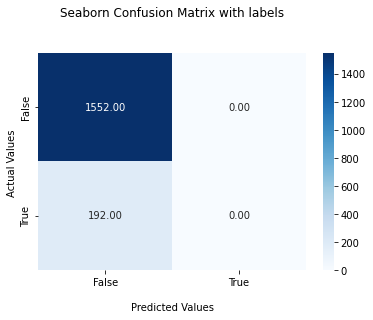

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred_labels)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.2f')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

This happens because when taking smaller batches, it is very likely that it will not contain samples of the minority class (positive), due to the high imbalance. Hence it will end up learning the pattern for the majority class (false) and after a couple of epochs, everything will be classified as the false class.

### Upsampling in training data . 
In the following we will try and model whether or not the article is a top article from the images

In [ ]:
train_df = pd.DataFrame({'filepath': X_train['filepath'], 'top_article': y_train['top_article']})
val_df = pd.DataFrame({'filepath': X_val['filepath'], 'top_article': y_val['top_article']})
test_df = pd.DataFrame({'filepath': X_test['filepath'], 'top_article': y_test['top_article']})

In [ ]:
#Checking the current distribution
train_df['top_article'].value_counts()

0.0    5563
1.0     715
Name: top_article, dtype: int64

In [ ]:
len(train_df)

6278

We would like to have around 3000 in each class. Let's try and fix the data to be more balanced.. 

To begin with we delete random rows of the negative class, such that it only consist of 3000 samples. 

In [ ]:
3000/5563

0.5392773683264426

In [ ]:
train_df = train_df.drop(train_df[train_df['top_article'] == 0].sample(frac=.45).index)

In [ ]:
#Checking the updated distribution
train_df['top_article'].value_counts()

0.0    3060
1.0     715
Name: top_article, dtype: int64

In [ ]:
3060/715

4.27972027972028

In [ ]:
positive_df = train_df[train_df['top_article'] == 1].sample(frac=1)
positive_df_2 = train_df[train_df['top_article'] == 1].sample(frac=0.3)

In [ ]:
train_df_new = pd.concat([train_df, positive_df, positive_df,positive_df, positive_df_2], ignore_index=True, axis=0)

In [ ]:
#Checking the updated distribution
train_df_new['top_article'].value_counts()

1.0    3074
0.0    3060
Name: top_article, dtype: int64

In [ ]:
#We also need to shuffle the data
train_df_new = train_df_new.sample(frac=1)

Ready to model

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df_new,
    x_col='filepath',
    y_col='top_article',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='top_article',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='top_article',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False)

Found 6134 validated image filenames.
Found 698 validated image filenames.
Found 1744 validated image filenames.


In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics = ['accuracy'])

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5)])

Epoch 1/100
192/192 [==============================] - 123s 631ms/step - loss: 0.6711 - accuracy: 0.5673 - val_loss: 0.6856 - val_accuracy: 0.3625
Epoch 2/100
192/192 [==============================] - 120s 627ms/step - loss: 0.6559 - accuracy: 0.5877 - val_loss: 0.5380 - val_accuracy: 0.7837
Epoch 3/100
192/192 [==============================] - 119s 618ms/step - loss: 0.6479 - accuracy: 0.6042 - val_loss: 0.5956 - val_accuracy: 0.6275
Epoch 4/100
192/192 [==============================] - 119s 620ms/step - loss: 0.6351 - accuracy: 0.6350 - val_loss: 0.6271 - val_accuracy: 0.5387
Epoch 5/100
192/192 [==============================] - 121s 632ms/step - loss: 0.6148 - accuracy: 0.6563 - val_loss: 0.7205 - val_accuracy: 0.4198
Epoch 6/100
192/192 [==============================] - 120s 622ms/step - loss: 0.6116 - accuracy: 0.6581 - val_loss: 0.7261 - val_accuracy: 0.4140
Epoch 7/100
192/192 [==============================] - 119s 621ms/step - loss: 0.5772 - accuracy: 0.7008 - val_loss: 0

In [ ]:
#model.save("drive/MyDrive/ABA project/CNN_classification_balanced.pb")

INFO:tensorflow:Assets written to: drive/MyDrive/ABA project/CNN_classification_balanced.pb/assets


In [ ]:
#Saving the history information
#pickle.dump(history.history, open("drive/MyDrive/ABA project/cnn_classification_balanced.pickle","wb"))

In [ ]:
#The opens the pickle
history_class_balanced = np.load("drive/MyDrive/ABA project/cnn_classification_balanced.pickle", allow_pickle=True)

In [ ]:
acc = history_class_balanced['accuracy']
val_acc =history_class_balanced['val_accuracy']
loss = history_class_balanced['loss']
val_loss = history_class_balanced['val_loss']
epochs = range(len(acc))

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(epochs), y=acc, mode='lines', name='training accuracy'))
fig.add_trace(go.Scatter(x=np.array(epochs), y=val_acc, mode='lines', name='validation accuracy'))
fig.update_layout(title='Training and validation accuracy, CNN classification (imbalanced)',
                   xaxis_title='epoch',
                   yaxis_title='mse')

fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(epochs), y=loss, mode='lines', name='training loss'))
fig.add_trace(go.Scatter(x=np.array(epochs), y=val_loss, mode='lines', name='validation loss'))
fig.update_layout(title='Training and validation loss, CNN classification (imbalanced)',
                   xaxis_title='epoch',
                   yaxis_title='mse')


fig.show()

In [ ]:
y_pred = np.squeeze(model.predict(test_images,verbose=1))
y_true = test_images.labels

55/55 [==============================] - 32s 581ms/step


In [ ]:
y_pred_labels = round_to_whole = [round(num) for num in y_pred]

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred_labels).ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

True Negatives:  1205
False Positives:  347
False Negatives:  127
True Positives:  65


In [ ]:
Accuracy = (tn+tp)/(tp+tn+fp+fn) 
print("Accuracy {:0.2f}".format(Accuracy))

Precision = tp/(tp+fp) 
print("Precision {:0.2f}".format(Precision))

Recall = tp/(tp+fn) 
print("Recall {:0.2f}".format(Recall))

Accuracy 0.73
Precision 0.16
Recall 0.34


In [ ]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred_labels)

0.21523178807947024

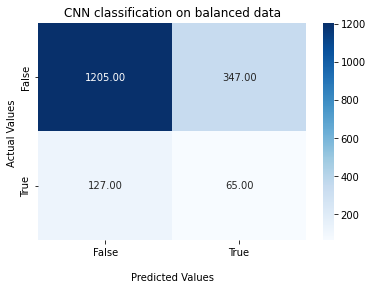

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred_labels)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='.2f')

ax.set_title('CNN classification on balanced data');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

<a id='part94'></a>

### 9.4 BERT model

From above it is evident that the often used ensemble algorithms, such as lightGBM, does a poor job of predicting the engagement count of news articles posted on facebook. 

**Introduction to BERT model**

Continuing in the text domain, one hypothesis may be that the semantic meaning and the order of the words is better at explaining the facebook engagement of an article. To model this we have used the NLP model called Bi-Directional Encoder Representations from Transformers (BERT) model. The model relies heavily on the "Transformer" architecture, which was introduced in the now infamous article, "Attention Is All You Need" [Vaswani et al. 2017]. The reason why we have chosen BERT instead of implementing an RNN is because the transformer architecture, that BERT utilizes, more or less has substituted LSTM and other recurrent neural network based models for NLP tasks. The main advantage of the transformer is that it allows faster training through parallelization, avoidance of the vanishing gradient problem, and enables transfer learning to a higher degree than before. There exists dozens of NLP models using the transformer architecture and we chose BERT because it has a proven track-record for a variety of tasks including regression, sentiment analysis, question answering, summarization and text generation.

You may wonder how this is possible; The transformer architecture of BERT allows for transfer-learning, thus a highly sophisticated pre-trained model can be downloaded and fine-tuned for the task in hand. In fact, the BERT model was pre-trained on 3.3 billion words (from wikipedia and Google's BooksCorpus) for 4 days in an unsupervised manner that has ensured that the transformer layers (110 million parameters) of the model has "learnt" the english language and the "spoken" world we live in. The transformer layers are the engine of the model and to accomodate the regression problem we add a dense layer that connects the output of the transformer layers to a single neuron which acts as our prediction.


To make a prediction, an input sentence (sequence of tokens) is fed to the model, and along with the token is a positional encoding. The positional encoding allows the model to interpret the correct meaning of a sentence accounting for the semantics of the words and also the context of the words - just as humans do - contrary to the tf-idf principle where the uniqueness and popularity of the words are the only sources of information. This information is passed through the model's 12 transformer layers which accomodates pattern recognisition in highly latent dimensions. Finally, it is sent through the added dense layer and a prediction is obtained.



**Implementation of BERT model**

To facilite the fine-tuning of the BERT model, the huggingface API has been used (www.huggingface.co). It is a platform created for cooperation and sharing of NLP models and datasets. As the fine-tuning of the BERT model is cumbersome (as it is recommended to fine-tune all 110 million parameters in transformer models), the training has been done using one of Colabs GPU's for speed enhancement. This means that the below cells are mostly copied from Colab, and thus not run in this local notebook. However, as the training is a central part it is included below. We install the required packages, here among the transformers (the huggingface api) and wandb (similar to TensorBoard). Next we load the tokenizer and the model of interest from the huggingface api, tokenize the data and create a custom dataset class (required by PyTorch framework). For the training of the model we take advantage of the Trainer argument that comes with the huggingface library, hence, we define the training arguments, evaluation metrics and finally the trainer object. The model is now easily trained.

To ensure that we do not overfit (which the model is very prone to), we use a validation set and use the *EarlyStoppingCallback*, which ensures that the training stops if we haven't improved the performance of the validation set in a while. A simple tuning of the hyperparameters of the training loop has been executed and the following hyperparameters were chosen. A learning rate of 5e-5, a batch_size of 16 and evaluation steps of 100. 






In [ ]:
!pip3 install transformers==4.8.2
!pip install wandb

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification,RobertaForSequenceClassification, RobertaTokenizer
from transformers import EarlyStoppingCallback

The data is loaded from the pickles. In the input, X, we use both the title and description, as both may contain information valuable for the model.

In [ ]:
X_train = pickle.load(open("drive/MyDrive/ABA project/X_train.p", "rb"))
X_val =  pickle.load(open("drive/MyDrive/ABA project/X_val.p", "rb"))
X_test =  pickle.load(open("drive/MyDrive/ABA project/X_test.p", "rb"))
y_train = pickle.load(open("drive/MyDrive/ABA project/y_train.p", "rb"))
y_val = pickle.load(open("drive/MyDrive/ABA project/y_val.p", "rb"))
y_test = pickle.load(open("drive/MyDrive/ABA project/y_test.p", "rb"))

X_train = list(X_train['title'] + X_train['description'])
X_val = list(X_val['title'] + X_val['description'])
X_test = list(X_test['title'] + X_test['description'])
y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

In [ ]:
#download the pre-trained model and tokenizer from the huggingface api. 
#Note that we download the model from BertForSequenceClassification, which may seem odd, but as we indicate
#that we only have one label the model in fact contains a regression layer on top.
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

In [ ]:
#The data is tokenized. We use a max_length of 128 tokens, which ensures that all words for all sentences are
#fed to the model.

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128)

In [ ]:
# Create torch dataset.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

#create dataset objects
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters

def compute_metrics_reg(p):
  pred, labels = p
  
  MSE = mean_squared_error(y_true = labels, y_pred = pred)
  r2 = r2_score(y_true = labels, y_pred = pred)
  MAE = mean_absolute_error(y_true = labels, y_pred = pred)
  RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

  return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

# Define Trainer
args = TrainingArguments(
    output_dir="Bert",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps = 100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    learning_rate = 5e-5, #5e-6 for Roberta
    load_best_model_at_end=True,
    report_to="wandb"
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

PyTorch: setting up devices


In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Rmse,Mse,R2,Mae
100,7.786100,7.138305,2.671761,7.138305,0.014342,2.312127
200,6.642000,6.374755,2.524828,6.374756,0.119773,2.094713
300,6.712900,6.267457,2.503489,6.267457,0.134589,2.096277
400,6.244800,6.248429,2.499686,6.248429,0.137216,2.102344
500,5.141600,6.221301,2.494253,6.221301,0.140962,2.030169
600,5.234100,6.390009,2.527847,6.390009,0.117667,2.047825
700,5.352200,7.104477,2.665422,7.104477,0.019013,2.181099
800,4.998600,6.734248,2.595043,6.734248,0.070134,1.997738
900,3.311800,6.971200,2.640303,6.971200,0.037416,2.061655
1000,3.726000,7.401993,2.720660,7.401993,-0.022068,2.123927


***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-100
Configuration saved in Bert/checkpoint-100/config.json
Model weights saved in Bert/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-200
Configuration saved in Bert/checkpoint-200/config.json
Model weights saved in Bert/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-300
Configuration saved in Bert/checkpoint-300/config.json
Model weights saved in Bert/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-400
Configuration saved in Bert/checkpoint-400/config.json
Model weights saved in Bert/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 1

TrainOutput(global_step=1000, training_loss=5.51501235961914, metrics={'train_runtime': 431.0396, 'train_samples_per_second': 436.944, 'train_steps_per_second': 27.352, 'total_flos': 1301656631962080.0, 'train_loss': 5.51501235961914, 'epoch': 2.54})


Above we see how the training loss and validation loss decreases. At a point (around 400-500 steps - equivalent to 1 epoch) the validition loss starts to increase again, which is indication of overfitting. To experience the best generalization error after 1 epoch should be understood in the light of the number of parameters in the model compared to the relative limited dataset.

As we used the option to load best model at end, we save the model state of step 500. We can now do inference on the model and run it on the unseen data (test dataset).

In [ ]:
# ----- 3. Predict -----#
# Load test data
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=128)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
y_pred, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
def evaluate(pred, label):
  labels = label
  MSE = mean_squared_error(y_true = labels, y_pred = pred)
  r2 = r2_score(y_true = labels, y_pred = pred)
  MAE = mean_absolute_error(y_true = labels, y_pred = pred)
  RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

  return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.9328157435774105,
 'mse': 5.817625617246185,
 'r2': 0.17319787498805883,
 'rmse': 2.411975459503306}

Text(0, 0.5, 'predicted')

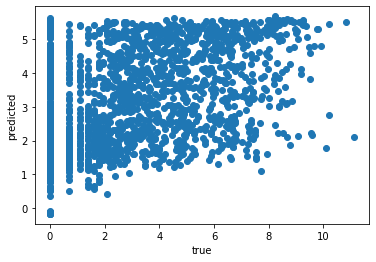

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("true")
plt.ylabel("predicted")

The BERT model is to some extent able to predict the engagement of a facebook article. The RMSE is 2.37 and the R2 score is 0.2. Thus compared to the LightGBM model (and baseline) the BERT model is better able to predict the facebook engagement. Intuitively, this makes sense as the context of the words and the semantic meaning should yield extra information compared to the tf-idf.


The model was uploaded to the huggingface library and can be found here https://huggingface.co/jenspt/bert_regression_basic_16_batch_size.

<a id='part95'></a>

### 9.5 BERT model with simple extension

In the descriptive analysis we saw that the engagement was correlated with the publisher. In the figure (reference - hvordan???) it was clear that New York Times??? was more likely to achieve articles with high engagement. Why don't we add this information to the model.

As we will be extending the previous BERT model with this information, we need to modify the structure of the model to accomodate an extra input vector corresponding to the publisher of the article. In practice the publisher column is a categorial and thus we simply do one-hot-encoding.



In [ ]:
#import dependencies
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss

#Load data from pickles
X_train_source = np.array(pd.get_dummies(X_train['source_name']))
X_val_source = np.array(pd.get_dummies(X_val['source_name']))
X_test_source = np.array(pd.get_dummies(X_test['source_name']))

X_train_text = list(X_train['title'] + X_train['description'])
X_val_text = list(X_val['title'] + X_val['description'])
X_test_text = list(X_test['title'] + X_test['description'])
y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

As we are creating a custom model, we this time need to create a class that extends the torch.nn.Module class. In this class we define the structure of our model, the forward pass and the loss function. 


In the inialization of the model, the pre-trained BERT model is downloaded without the dense layer for regression. A "custom" dense layer is specified where the input dimension is equal to that of the BERT output + the publisher vector. It is in this way that the publisher information is included in the model.

A forward pass consists of the tokenized text input going through the BERT model. Afterwards the BERT output is concatenated with the publisher vector which is then sent through the regression dense layer. Thus, the publisher vector works as a bias term in the model. To avoid unnecessary overfitting, a dropout is used during training for the dense layer (and automatically also for the bert model).

The loss is simply the mean squared error - similar to what we used in the previous model.

In [ ]:
#Custom model
class BertSource(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()

        D_in_Bert = 768
        D_in_source = 12 #different source_names
        D_out = 1

        #download "pure" BERT model from huggingface
        self.bert = BertModel.from_pretrained("bert-base-uncased")   


        #dense layer
        self.dropout = nn.Dropout(drop_rate)
        self.regressor = nn.Linear(D_in_Bert+D_in_source, D_out) 

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        source=None,
    ):

        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        #from bert
        pooled_output = bert_outputs[1]
        pooled_output = self.dropout(pooled_output)
        

        #combined
        combined_output = torch.cat([pooled_output, source], dim = 1)

        logits = self.regressor(combined_output)

        loss = None
        if labels is not None:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
            

        return (loss, logits)


In [ ]:
#init model
model = BertSource(drop_rate=0.2)

In [ ]:
#The dataset class now needs to handle the publisher data
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, source, labels=None):
        self.encodings = encodings
        self.labels = labels
        self.source = source

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["source"] = torch.squeeze(torch.tensor(self.source[idx,:])) # add source_name to dataset
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, X_train_source, y_train)
val_dataset = Dataset(X_val_tokenized, X_val_source, y_val)

In [ ]:
#We define a new Trainer object using the new model
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [ ]:
# and we train again...
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Rmse,Mse,R2,Mae
100,7.338400,6.362899,2.522479,6.362899,0.121410,2.087140
200,6.441900,6.935297,2.633495,6.935297,0.042374,2.248472
300,6.590600,6.899514,2.626693,6.899514,0.047314,2.210473
400,6.391500,5.848731,2.418415,5.848731,0.192407,1.982033
500,5.061200,5.819581,2.412381,5.819581,0.196432,1.961285
600,4.926600,6.262276,2.502454,6.262276,0.135304,1.991376
700,5.202100,5.803336,2.409011,5.803336,0.198675,1.939768
800,4.939200,7.080579,2.660936,7.080579,0.022313,2.077828
900,3.464400,6.288102,2.507609,6.288102,0.131738,1.954899
1000,3.505400,7.085421,2.661845,7.085421,0.021644,2.080502


***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evalua

TrainOutput(global_step=1200, training_loss=5.031382548014323, metrics={'train_runtime': 573.1771, 'train_samples_per_second': 328.59, 'train_steps_per_second': 20.57, 'total_flos': 0.0, 'train_loss': 5.031382548014323, 'epoch': 3.05})

This time the best model is at step 700 - so rougly after 1.5 epoch.

In [ ]:
# ----- 3. Predict -----#
# Load test data
X_test_tokenized = tokenizer(X_test_text, padding=True, truncation=True, max_length=128)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized, X_test_source, y_test)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
y_pred, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.9050843896626328,
 'mse': 5.6908150668099085,
 'r2': 0.19122021596920258,
 'rmse': 2.385542929148396}

We can see that the performance of the model has increased! We now have a RMSE of 2.38 and a R2 of 0.19. Still far from perfect but it shows that the model is able to learn the biases of the publishers.


<a id='part96'></a>

### 9.6 A SuperModel!

So far we have tried to model the engagement based on the text and the images seperately. What if we combine the two models and thus try to make a super model that uses information from both the images and the text - exactly what us humans do when scrolling through facebook!


To do this we need to incorporate the images into the model and dataset classes. As the previous image CNN was implemented in Keras we need to reimplement it in PyTorch such that it is compatible with the above model. Furthermore, to accomodate transfer learning it was decided to add an extra dense layer with 10 neurons between the current convolutional layers and dense layer (conv2d -> dense (10) -> dense (1). When we do transfer learning we can then use the 10 neurons and concatenate it with the information from the text and the publisher. The 10 neurons can be interpreted as 10 different latent classes that an image can belong to.

To ensure the best learning possibilities for the model, we need to firstly pre-train the basic CNN model on the dataset and afterwards fine-tune - just like what we do with the BERT model. The pre-training has been done with a learning rate of 0.001, whereas the fine-tuning is done with a learning rate of 5e-5. If we didn't have this difference we would in the fine-tuning phase alter the weights of the BERT model too much and essentially overfitting the model to the training data. The training of the basic CNN model can be found in the appendix but it can be said that we obtain similar results as in part 9.3.


To build this super model we need to define a new PyTorch model aswell as dataset class.




In [ ]:
from torchvision import transforms

In [ ]:
X_train_source = np.array(pd.get_dummies(X_train['source_name']))
X_val_source = np.array(pd.get_dummies(X_val['source_name']))
X_test_source = np.array(pd.get_dummies(X_test['source_name']))

X_train_image = np.array(X_train['filepath'])
X_val_image = np.array(X_val['filepath'])
X_test_image = np.array(X_test['filepath'])

X_train_text = list(X_train['title'] + X_train['description'])
X_val_text = list(X_val['title'] + X_val['description'])
X_test_text = list(X_test['title'] + X_test['description'])

y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

In [ ]:
#Custom model
class SuperModel(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()

        D_in_Bert = 768
        D_in_source = 12 #different source_names
        D_in_image = 10
        D_out = 1

        #bert
        self.bert = BertModel.from_pretrained("bert-base-uncased")
      


        #load pre-trained cnn and use all pre-trained layers but the last.
        image_full = torch.load("drive/MyDrive/ABA project/NN_models/image")
        self.conv1 = image_full.conv1
        self.conv2 = image_full.conv2
        self.l_1_image = image_full.l_1_image


        #final dense layer with 768 + 12 + 10 inputs.
        self.dropout = nn.Dropout(drop_rate)
        self.regressor = nn.Linear(D_in_Bert+D_in_source+ D_in_image, D_out)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        source=None,
        image=None,
    ):

        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        #from bert
        pooled_output = bert_outputs[1]
        pooled_output = self.dropout(pooled_output)

       
        #define CNN. Identical to the one implemented in Keras except the additional
        #dense layer
        x_image = image
        x_image = self.conv1(x_image)
        x_image = F.relu(x_image)
        x_image = F.max_pool2d(x_image,2)
        x_image = self.conv2(x_image)
        x_image = F.relu(x_image)
        x_image = F.max_pool2d(x_image,2)
        x_image = F.max_pool2d(x_image,(28,28))
        x_image = x_image.squeeze()
        x_image = F.relu(self.l_1_image(x_image))
        x_image = self.dropout(x_image)
        

        #combined
        combined_output = torch.cat([pooled_output, source, x_image], dim = 1)

        logits = self.regressor(combined_output)

        loss = None
        if labels is not None:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
            

        return (loss, logits)


In [ ]:
model = SuperModel(drop_rate=0.2)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Define pretrained tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# ----- 1. Preprocess data -----#
# Preprocess data
X_train_tokenized = tokenizer(X_train_text, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val_text, padding=True, truncation=True, max_length=128)

In [ ]:
#Image: Create method that transform image from .jpeg to tensor
#We need to resize and normalize picture. We use the default normalization values found in PyTorch documentation.
transform = transforms.Compose([
  transforms.Resize((120,120)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  ])

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, source, image, image_transform, labels=None):
        self.encodings = encodings
        self.labels = labels
        self.source = source

        self.image_transform = image_transform
        self.image_path = image

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["source"] = torch.squeeze(torch.tensor(self.source[idx,:])) # add source_name to dataset
        
        #add image - very cumbersome as we have to load images from google drive.
        img_loc = self.image_path[idx]
        image = Image.open(img_loc).convert("RGB")
        item["image"] = self.image_transform(image) #transform to tensor, rescale and normalize
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, X_train_source, X_train_image, transform, y_train)
val_dataset = Dataset(X_val_tokenized, X_val_source, X_val_image, transform, y_val)

In [ ]:
# ----- 2. Fine-tune pretrained model -----#

# Define Trainer
args = TrainingArguments(
    output_dir="SuperBert",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps = 100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    load_best_model_at_end=True,
    report_to="wandb",
    learning_rate = 5e-5,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)

PyTorch: setting up devices


In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Rmse,Mse,R2,Mae
100,7.319100,6.197211,2.489420,6.197211,0.144289,2.043956
200,6.575400,6.260998,2.502199,6.260998,0.135481,2.090090
300,6.638400,6.136249,2.477145,6.136249,0.152706,2.025047
400,6.418900,6.416091,2.533000,6.416091,0.114065,2.014795
500,5.292900,6.244785,2.498957,6.244786,0.137719,1.978070
600,5.283300,6.559135,2.561081,6.559135,0.094314,2.016098
700,5.191200,5.942778,2.437782,5.942779,0.179421,1.960896
800,5.129900,6.638940,2.576614,6.638940,0.083294,1.985253
900,3.569200,6.100891,2.469998,6.100891,0.157588,1.904677
1000,3.634000,7.191604,2.681716,7.191604,0.006983,2.082386


***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Ru

TrainOutput(global_step=1700, training_loss=4.316432100183824, metrics={'train_runtime': 7436.6687, 'train_samples_per_second': 25.326, 'train_steps_per_second': 1.585, 'total_flos': 0.0, 'train_loss': 4.316432100183824, 'epoch': 4.33})

In [ ]:
# ----- 3. Predict -----#
X_test_tokenized = tokenizer(X_test_text, padding=True, truncation=True, max_length=256)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized, X_test_source, X_test_image, transform, y_test)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = raw_pred# np.argmax(raw_pred, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.9349990330079698,
 'mse': 5.848133499322388,
 'r2': 0.16886208863985486,
 'rmse': 2.4182914421802817}

This is an interesting result. The model performance does not improve as we expected. This can be due to three things; either the image does not add extra information when you already have the text and is thus just a noisy signal - this is unlikely. It could also be that the structure of the model is unbalanced in regards to the inputs to the final dense layer. The CNN only has 10 inputs, whereas the BERT model has 768 inputs. Thirdly, it could be that the fine-tuning of the model has not been done properly and that a more sophisticated fine-tuning is required. This could for instance be to freeze some layers of the CNN, while training on the BERT and vice versa. For future work, we suggest to look at the latter point.

**Back to original domain of interest**

Thus, the facebook engagement has been predicted in the log domain. It is clear that the BERT model with publisher information is the best model and it now time to convert the predictions into the original domain.

## Appendix: CNN in PyTorch

In [ ]:
#Custom model
class CNNModel(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()

        D_in_image = 10
        D_out = 1

        #cnn based on images
        input_channels = 3
        self.conv1 = nn.Conv2d(in_channels=input_channels,
                               out_channels=16,
                               kernel_size=5,)
        self.conv2 = nn.Conv2d(in_channels=16, 
                               out_channels=32,
                               kernel_size=3)
        #self.conv2_drop = nn.Dropout2d()
        self.l_1_image = nn.Linear(in_features = 32, out_features = 10)
        


        #dense layer
        self.dropout = nn.Dropout(drop_rate)
        self.regressor = nn.Linear(D_in_Bert+D_in_source+ D_in_image, D_out) 

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        source=None,
        image=None,
    ):

        #image
        x = image
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = F.max_pool2d(x,(28,28))
        x = x.squeeze()
        x = F.relu(self.l_1_image(x))

        logits = self.regressor(x)#(pooled_output)

        loss = None
        if labels is not None:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
            

        return (loss, logits)


In [ ]:
model = CNNModel(drop_rate=0.2)

In [ ]:
#Image: Create method that transform image from .jpeg to tensor
#We need to resize and normalize picture
transform = transforms.Compose([
  transforms.Resize((120,120)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  ])

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, source, image, image_transform, labels=None):
        self.encodings = encodings
        self.labels = labels
        self.source = source

        self.image_transform = image_transform
        self.image_path = image

    def __getitem__(self, idx):
        item = {}
        img_loc = self.image_path[idx]
        image = Image.open(img_loc).convert("RGB")
        item["image"] = self.image_transform(image) #transform to tensor, rescale and normalizeW
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_image, transform, y_train)
val_dataset = Dataset(X_val_image, transform, y_val)

In [ ]:
# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters

# Define Trainer
args = TrainingArguments(
    output_dir="image",
    evaluation_strategy="epoch",
    eval_steps=1,
    logging_steps = 1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    load_best_model_at_end=True,
    report_to="wandb",
    learning_rate = 0.001,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

PyTorch: setting up devices


In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Rmse,Mse,R2,Mae
1,5.752400,7.412351,2.722563,7.412351,-0.023498,2.275134
2,2.979600,7.215787,2.686222,7.215787,0.003643,2.240338
3,2.323400,6.786705,2.605130,6.786705,0.062891,2.153294
4,9.362900,6.629194,2.574722,6.629194,0.084640,2.152106
5,2.804700,6.705364,2.589472,6.705364,0.074123,2.135092
6,4.593700,6.603457,2.569719,6.603457,0.088194,2.124525
7,3.559300,6.626361,2.574172,6.626361,0.085031,2.137789
8,5.002800,6.595428,2.568156,6.595428,0.089303,2.120844
9,3.331700,6.638323,2.576494,6.638323,0.083380,2.121290
10,11.321500,7.008771,2.647408,7.008771,0.032228,2.242180


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to image/checkpoint-393
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to image/checkpoint-786
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images w

TrainOutput(global_step=7074, training_loss=6.6870990285756795, metrics={'train_runtime': 5664.0779, 'train_samples_per_second': 33.252, 'train_steps_per_second': 2.082, 'total_flos': 0.0, 'train_loss': 6.6870990285756795, 'epoch': 18.0})

In [ ]:
# ----- 3. Predict -----#

# Create torch dataset
test_dataset = Dataset(X_test_image, transform, y_test)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
y_pred, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
evaluate(y_pred, y_test)

{'mae': 2.105758069301436,
 'mse': 6.476038443584958,
 'r2': 0.07962411143438064,
 'rmse': 2.5448061701404603}

In [ ]:
torch.save(model,"drive/MyDrive/ABA project/NN_models/image")